Back to the main [Index](../index.ipynb)

# Tasks, Workflows and Flow

Before starting, it's worth clarifying some of the basic concepts used in `AbiPy` to automate ab-initio calculations. 
In particular, in this paragraph we will focus on the following three objects: 

   * `Task`
   * `Work`
   * `Flow`
   
The `Task` represent the most elementary step of the calculation. 
Roughly speaking, it corresponds to the execution of an ABINIT run.
From the point of view of `Abipy`, a calculation consists of a set of `Tasks` that are connected together by some sort of dependency. 
Each task has a list of files that are needed to start the calculation, and a list of files that are produced at the end of the run.
Some of the input files needed by a `Task` must be provided by the user in the form of ABINIT input variables 
(e.g. the crystalline structure), other inputs may be produced by other tasks.
When a `Task` B requires the output file `DEN` of another calculation A, we say that B depends on A through F, and we express this dependency using the python dictionary  

```python
B_deps = {A: "DEN"}
```

To clarify this point, let's take a standard $KS$ band structure calculation as example.
In this case, we have an initial `ScfTask` that solves the KS equations self-consistently to produce a density file. 
The density is then used by a second `NscfTask` to produce a band structure on an arbitrary 
set of $k$-points.
The `NscfTask` has thus a dependency on the first `ScfTask` in the sense that it cannot be executed until the `ScfTask` is completed, and the `DEN` file produced by the `ScfTask` is needed as input.

The `Work` can be seen as a list of `Tasks`, while the `Flow` is a list of `Work` objects.
End-users will mainly interact with the `Flow` since this object provides an easy-to-use
interface for performing common operations (launching jobs, checking the status of the `Tasks` etc). 

`AbiPy` provides several factory functions for typical first-principles calculations.
This means that you do not need to understand all the technical details of 
the python implementation.
In many cases, indeed, we already provide some kind of `Work` or `Flow` that automates 
your calculation, and you only have to provide the correct list of input files 
that obviously must be consistent with the Flow/Work that is being created.
(you shall not pass a list of inputs for performing a band structure calculation to a flow 
that is expected to compute phonons with DFPT!

All the `Works` and the `Tasks` of a flow are created and executed inside the `Flow` working directory (`workdir`) 
that is usually specified by the user during the creation of the `Flow`.
`Abipy` will then create the workdir of the different Works/Tasks when the `Flow` is executed
for the first time.

Each `Task` has an associated set of input variables that will be used to generate the ABINIT input file and run the calculation. 
This input **must** be provided by the user during the creation of the `Task`.
Fortunately, `AbiPy` provides an object named `AbinitInput` that facilitates the creation 
of such input. 
Once you have an `AbinitInput`, you can create the corresponding `Task` with the pseudo code:

```python
new_task = Task(abinit_input)
```

The `Task` provides several methods for monitoring the status of the ABINIT run and 
post-processing the results.

In the next paragrap, we discuss how to construct a `Flow` for band-structure calculations
with a high-level interface that only requires the specifications on the input files.
This example allows us to discuss the most important methods of the `Flow`.

## Building a `Flow` for the band structure of Silicon.

Let's start by creating a functions that will produce two input files. 
The first input is a standard self-consistent ground-state calculation.
The second dataset uses the density produced in the first run to perform a non self-consistent band structure calculation.

In [4]:
from __future__ import division, print_function, unicode_literals

%matplotlib notebook

import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

from abipy import abilab
import abipy.flowtk as flowtk
import abipy.data as abidata

def make_scf_nscf_inputs():
    """Build ands return the input files for the GS-SCF and the GS-NSCF tasks."""
    multi = abilab.MultiDataset(structure=abidata.cif_file("si.cif"),
                              pseudos=abidata.pseudos("14si.pspnc"), ndtset=2)

    # Set global variables (dataset1 and dataset2)
    multi.set_vars(ecut=6, nband=8)

    # Dataset 1 (GS-SCF run)
    multi[0].set_kmesh(ngkpt=[8,8,8], shiftk=[0,0,0])
    multi[0].set_vars(tolvrs=1e-6)

    # Dataset 2 (GS-NSCF run on a k-path)
    kptbounds = [
        [0.5, 0.0, 0.0], # L point
        [0.0, 0.0, 0.0], # Gamma point
        [0.0, 0.5, 0.5], # X point
    ]

    multi[1].set_kpath(ndivsm=6, kptbounds=kptbounds)
    multi[1].set_vars(tolwfr=1e-12)
    
    # Return two input files for the GS and the NSCF run
    scf_input, nscf_input = multi.split_datasets()
    return scf_input, nscf_input

Once we have our two input files, we pass them to the 
factory function `bandstructure_flow` that returns our `Flow`.

In [5]:
scf_input, nscf_input = make_scf_nscf_inputs()

workdir = "/tmp/hello_bands"
flow = flowtk.bandstructure_flow(workdir, scf_input, nscf_input)

`bandstructure_flow` took care of creating the correct dependency between the two tasks.
The `NscfTask`, indeed,  depends on the `ScfTask` in w0/t0, whereas the `ScfTask` has no dependency

**Note** that we don't have to use `getden2 = -1` in the second dataset since `Abipy` knows how to connect the two steps.

<IPython.core.display.Javascript object>


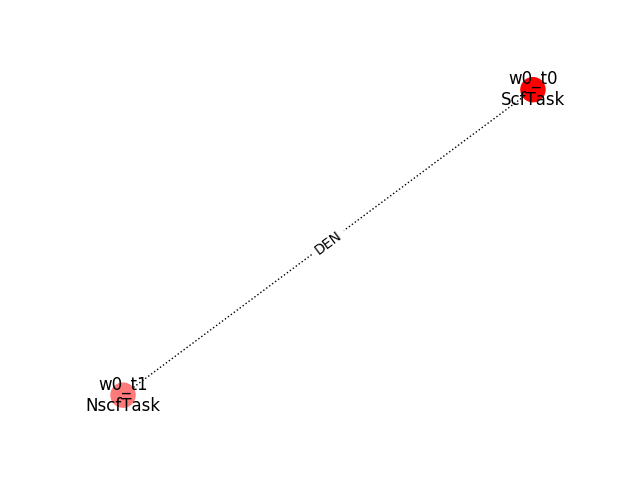

In [6]:
flow.plot_networkx(with_edge_labels=True);

To have useful information on the status of the flow, one uses:

In [7]:
flow.show_status()


Work #0: <BandStructureWork, node_id=201107, workdir=../../../../../../../../tmp/hello_bands/w0>, Finalized=False
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+
| Task   | Status      | Queue   | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time   |   Node_ID |
+========+=============+=========+==============+============+==========+=================+========+===========+
| w0_t0  | Initialized | None    | 1|  1|2.0    | NA|NA      | ScfTask  | (0, 0, 0)       | None   |    201108 |
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+
| w0_t1  | Initialized | None    | 1|  1|2.0    | NA|NA      | NscfTask | (0, 0, 0)       | None   |    201109 |
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+



Meaning of the different columns:
    
   * Task: short name of the task (usually t[index_in_work]
   * Status: Status of the task
   * Queue: Job identifier returned by the resource manager when the task is submitted
   * (MPI| OMP |Memproc): Number of MPI procs, OMP threads, and memory per MPI proc
   * Err|Warn|Comm: Number of Error/Warning/Comment messages found in the ABINIT log
   * Class: The class of the `Task`
   * Restart: Number of restart performed
   * Node_ID : identifier of the task, used to select tasks or works in python code or `abirun.py`

## How to build and run the `Flow`

The flow is still in memory and no file has been produced. In order to build the workflow, we use 

In [8]:
retcode = flow.build_and_pickle_dump()

This function creates the directories of the `Flow`:

In [9]:
!tree /tmp/hello_bands

/tmp/hello_bands
├── __AbinitFlow__.pickle
├── indata
├── outdata
├── tmpdata
└── w0
    ├── indata
    ├── outdata
    ├── t0
    │   ├── indata
    │   ├── job.sh
    │   ├── outdata
    │   ├── run.abi
    │   ├── run.files
    │   └── tmpdata
    ├── t1
    │   ├── indata
    │   ├── job.sh
    │   ├── outdata
    │   ├── run.abi
    │   ├── run.files
    │   └── tmpdata
    └── tmpdata

15 directories, 7 files


`w0` is the directory containing the input files of the first workflow (well, we have only one workflow in our example).
`t0` and `t1` contain the input files need to run the SCF and the NSC run, respectively.

You might have noticed that each `Task` directory present the same structure:
    
   * run.abi: ABINIT input file
   * run.files: ABINIT files file
   * job.sh: Submission script
   * outdata: Directory containing output data files
   * indata: Directory containing input data files 
   * tmpdata: Directory with temporary files

<div class="alert alert-error">
 `__AbinitFlow__.pickle` is the pickle database used to store the `Flow` we have just created. **Don't touch it!** 
</div>

## Executing a `Flow`

The `Flow` can be executed with two different approaches: a programmatic interface based on `make_scheduler` and the `abirun.py` script. 
In this section, we present the first approach. 

In [10]:
flow.make_scheduler().start()

[Sat Oct 14 01:34:50 2017] Number of launches: 1

Work #0: <BandStructureWork, node_id=201107, workdir=../../../../../../../../tmp/hello_bands/w0>, Finalized=False
+--------+-------------+-----------------+--------------+------------+----------+-----------------+----------+-----------+
| Task   | Status      | Queue           | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time     |   Node_ID |
+========+=============+=================+==============+============+==========+=================+==========+===========+
| w0_t0  | Submitted   | 84296@localhost | 2|  1|2.0    | 0|  0      | ScfTask  | (1, 0, 0)       | 0:00:00Q |    201108 |
+--------+-------------+-----------------+--------------+------------+----------+-----------------+----------+-----------+
| w0_t1  | Initialized | None            | 1|  1|2.0    | NA|NA      | NscfTask | (0, 0, 0)       | None     |    201109 |
+--------+-------------+-----------------+--------------+------------+----------+-----------------

0

In the first iteration, only the `ScfTask` is executed because the second task depends on it. 
At this point the scheduler will regularly wakes up, inspect the `Tasks` in the flow and 
submit those whose dependency is fulfilled.

<IPython.core.display.Javascript object>


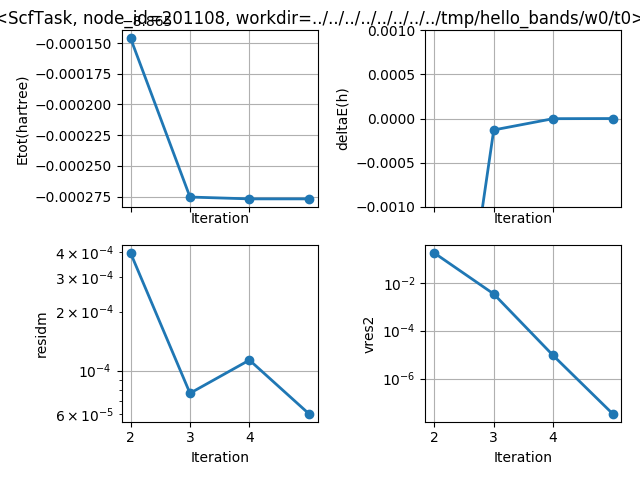

Task <NscfTask, node_id=201109, workdir=../../../../../../../../tmp/hello_bands/w0/t1> does not provide an inspect method


In [11]:
flow.inspect()

## More on `Works` and `Tasks` 

Both `Flow` and `Work` are iterable. 
Iterating on a `Flow` gives `Work` objects, whereas
iterating over a `Work` will give the `Tasks` inside that particular `Work`.

```python
for work in flow:
    for task in work:
        print(task)
```

One can also "slice" `Flows` and `Works` i.e. one can select a slice or works or tasks
with the syntax: flow[start:stop] or work[start:stop]
This means that the previous loop is equivalent to the much more verbose version: 

```python
for i in range(len(flow)):
    work = flow[i]
    for t in range(len(work):
        print(work[t])
```

## TaskManager

In the previous sections, we have discussed how to define, build and run a `Flow`, but there is a very important point that we haven't discussed yet.
It should be stressed, indeed, that `AbiPy` is only driving and monitoring the `Flow` while the actual calculation is delegated to ABINIT (a Fortran program that is usually executed in parallel on multiple CPUs that communicate via the network by means of the MPI protocol).
Besides CPUs and memory must be reserved in advance by sending a request to the resource manager installed on the clusters (SLURM, PBS, etc)

`AbiPy` gets all the information needed to submit the different `Tasks` from a configuration file, `manager.yml`, that is usually located in the directory `~/.abinit/abipy/`. 


<div class="alert alert-success">
For a brief introduction to the YAML format, please consult http://en.wikipedia.org/wiki/YAML
</div>

`manager.yml` contains a list of `QueueAdapters` objects. 
Each `QueueAdapter` is responsible for all interactions with a specific queue management system (slurm, PBS, bash, etc).
This includes handling all details of queue script format as well as queue submission and management.
The configuration file I use on my laptop is:

qadapters:
    # List of qadapters objects 
    - priority: 1
      queue:
        qtype: shell
        qname: gmac
      job:
        mpi_runner: mpirun
        pre_run: "source ~/env.sh"
      limits:
        timelimit: 1:00:00
        max_cores: 2
      hardware:
         num_nodes: 1
         sockets_per_node: 1
         cores_per_socket: 2
         mem_per_node: 4 Gb

For the sake of brevity, we just try to give you a general overview of the meaning 
of the different sections without entering into detail.
 
* queue: dictionary with the name of the queue and optional parameters 
     used to build/customize the header of the submission script.
* job: dictionary with the options used to prepare the enviroment before submitting the job
* limits: dictionary with the constraints that must be fulfilled in order to run with this queueadapter.
* hardware: dictionary with information on the hardware available on this particular queue.

In this (simple) case, we have one `QueueAdapter` named `gmac` that will submit `Tasks`
in a shell subprocess (`qtype: shell`) via mpirun. 
`env.sh` is the bash script I use to set the value of the environment variables (e.g. `PATH` and `LD_LIBRARY_PATH`) before running ABINIT.

Note that my laptopt has 1 socket with 2 CPUs and 4 Gb of memory in total, hence I don't want
to run ABINIT tasks with more than 2 CPUs. This is the reason why `max_cores` is set to 2.
`Timelimit` is not used when you are using `qname=shell`, but it is very important when you are submitting jobs on a cluster because this value is used to generate the submission script.

At this point, you may wonder why we need to specify all these parameters in the configuration file.
The reason is that, before submitting a job to a resource manager, `AbiPy` will use the autoparal feature of ABINIT to get all the possible parallel configurations with `ncpus <= max_cores`. 
On the basis of these results, `AbiPy` selects the "optimal" one, and changes the ABINIT input file and the submission script sccordingly .
(this is a very useful feature, especially for calculations done with `paral_kgb=1` that require the specification of `npkpt`, `npfft`, `npband`, etc).
If more than one `QueueAdapter` is specified, `AbiPy` will first compute all the possible configuration and then select the "optimal" `QueueAdapter` according to some kind of policy.

The complete list of options supported by the `TaskManager` with slurm can be 
retrieved with the command:

In [12]:
!abirun.py . manager slurm

usage: abirun.py [-h] [-V]
                 [flowdir]
                 {single,rapid,scheduler,batch,status,set_status,cancel,restart,reset,move,open,ncopen,abibuild,doc_scheduler,gui,new_manager,tail,qstat,deps,robot,plot,inspect,inputs,abivars,structures,ebands,doc_manager,events,corrections,history,handlers,notebook,ipython,tar,debug,debug_reset,group,diff,networkx,listext,timer}
                 ...
abirun.py: error: argument command: invalid choice: 'manager' (choose from 'single', 'rapid', 'scheduler', 'batch', 'status', 'set_status', 'cancel', 'restart', 'reset', 'move', 'open', 'ncopen', 'abibuild', 'doc_scheduler', 'gui', 'new_manager', 'tail', 'qstat', 'deps', 'robot', 'plot', 'inspect', 'inputs', 'abivars', 'structures', 'ebands', 'doc_manager', 'events', 'corrections', 'history', 'handlers', 'notebook', 'ipython', 'tar', 'debug', 'debug_reset', 'group', 'diff', 'networkx', 'listext', 'timer')


<div class="alert alert-success">
`Abipy` will read the `manager.yml` file automatically when a new `Flow` is created. 
By default, python looks for a `manager.yml` file in the current working directory and 
then in `~/.abinit/abipy`. 
</div>

## Scheduler

The other configuration file is named `scheduler.yml` and defines the parameters 
for the scheduler that will run/submit our jobs

In [13]:
!cat ~/.abinit/abipy/scheduler.yml

# number of weeks to wait.
#weeks: 0

# number of days to wait.
#days: 0

# number of hours to wait.
#hours: 0

# number of minutes to wait.
#minutes: 0

# number of seconds to wait.
seconds: 10

# when to first execute the job and start the counter (default is after the given interval).
#start_date:

# Send mail to the specified address (accepts string or list of strings).
# PRO TIP: the scheduler WILL try to send and email after a default time of 4 days. If you 
#          comment out the mailto address, this will cause the scheduler to terminate, with
#          potentially nefarious effects on your running jobs. If you do not wish to receive
#          emails, a work around is to set the variable `remindme_s` below to something very
#          large (say, 100 days).
#mailto: nobody@nowhere.com

# verbosity level (int, default 0)
#verbose: 0

# The scheduler will shutdown when the number of python exceptions is > max_num_pyexcs
#max_num_pyexcs: 2

# The scheduler will shutdown when 

<div class="alert alert-success">
Also in this case, `Abipy` will read the `scheduler.yml` file automatically when `make_scheduler` 
is called without arguments. 
A file `manager.yml` located in the current working directory takes precedence over `~/.abinit/abipy/manager.yml`. 
</div>

<div class="alert alert-error">
Remember to set the time interval of the scheduler to a reasonable value.
A small value leads to an increase of the submission rate but it also increases the CPU load 
and the pressure on the hardware and on the resource manager.
A too large time interval can have a detrimental effect on the throughput, especially 
if you are submitting many small jobs.
</div>

## Abirun.py

Executing `flow.make_scheduler().start()` inside an ipython notebook is handy if you are dealing with small calculations that require few seconds or minutes. 
This approach, however, is unpractical when you have large flows or big calculations requiring hours or days, even on massively parallel machines.
In this case, indeed, one would like to run the scheduler in a separate process in the backgroud so that the scheduler is not killed when the ipython notebook server is closed.

To start the scheduler in a separate process, use the `abirun.py` script.
The syntax is 

```bash
$> abirun.py flow_workdir command
```

where `flow_workdir` is the directory containing the `Flow` (the directory with the pickle file) and `command` selects the operation to be performed.

Typical examples:

```bash
$> abirun.py /tmp/hello_bands status
```
checks the status of the `Flow` and print the results to screen.

```bash
$> nohup abirun.py /tmp/hello_bands scheduler > sched.log &
```

Starts the scheduler in the background redirecting the standard output to file `sched.log`

<div class="alert alert-success">
`nohup` is a standard Unix tool. The command make the scheduler immune 
to hangups so that you can close the shell session without killing the scheduler.
</div>

`--help` gives the complete list of commands and options available: 

In [14]:
!abirun.py --help

usage: abirun.py [-h] [-V]
                 [flowdir]
                 {single,rapid,scheduler,batch,status,set_status,cancel,restart,reset,move,open,ncopen,abibuild,doc_scheduler,gui,new_manager,tail,qstat,deps,robot,plot,inspect,inputs,abivars,structures,ebands,doc_manager,events,corrections,history,handlers,notebook,ipython,tar,debug,debug_reset,group,diff,networkx,listext,timer}
                 ...

positional arguments:
  flowdir               File or directory containing the ABINIT
                        flow/work/task. If not given, the flow in the current
                        workdir is selected.

optional arguments:
  -h, --help            show this help message and exit
  -V, --version         show program's version number and exit

subcommands:
  Valid subcommands

  {single,rapid,scheduler,batch,status,set_status,cancel,restart,reset,move,open,ncopen,abibuild,doc_scheduler,gui,new_manager,tail,qstat,deps,robot,plot,inspect,inputs,abivars,structures,ebands,doc_manager,e